Не всё понятно - почему так.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import tensorflow as tf

In [2]:
import zipfile

data_r = zipfile.ZipFile('06 train.zip', 'r')
data_r.extractall()

In [3]:
data_r = zipfile.ZipFile('06 test.zip', 'r')
data_r.extractall()

In [2]:
def download_data(path):
  data = []
  for path_image in sorted(os.listdir(path=path)):
    image = Image.open(path + path_image) #Открываем изображение.
    data.append(np.array(image)) #Загружаем пиксели.
  return data

In [3]:
X_train = download_data(r"train/images/")
Y_train = download_data(r"train/masks/")
X_test = download_data(r"test/images/")
Y_test = download_data(r"test/masks/")

In [45]:
len(X_train)

7

Очень уж маленькая выборка для обучения...

In [4]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [5]:
X_train, Y_train = resize(X_train, Y_train)

In [6]:
X_test, Y_test = resize(X_test, Y_test)

Что за четвёртое число в списке цвета? Хотел предположить, что это принадлежность к определённой области, пусть и ненормированная, но оно одинаково для любого цвета.<br>
И одновременно - а не навредит ли это при сегментации? Ведь по должно быть только три числа.

In [8]:
Y_test

<tf.Tensor: shape=(2, 128, 128, 4), dtype=int32, numpy=
array([[[[132,  41, 246, 255],
         [132,  41, 246, 255],
         [132,  41, 246, 255],
         ...,
         [132,  41, 246, 255],
         [132,  41, 246, 255],
         [132,  41, 246, 255]],

        [[132,  41, 246, 255],
         [132,  41, 246, 255],
         [132,  41, 246, 255],
         ...,
         [132,  41, 246, 255],
         [132,  41, 246, 255],
         [132,  41, 246, 255]],

        [[132,  41, 246, 255],
         [137,   5, 250, 255],
         [110, 193, 228, 255],
         ...,
         [132,  41, 246, 255],
         [132,  41, 246, 255],
         [132,  41, 246, 255]],

        ...,

        [[132,  41, 246, 255],
         [132,  41, 246, 255],
         [132,  41, 246, 255],
         ...,
         [226, 169,  41, 255],
         [226, 169,  41, 255],
         [226, 169,  41, 255]],

        [[132,  41, 246, 255],
         [132,  41, 246, 255],
         [132,  41, 246, 255],
         ...,
         [226, 

In [9]:
palette = {0 : (60, 16, 152), # Building
           1 : (132, 41, 246), # Land
           2 : (110, 193, 228), # Road
           3 : (254, 221, 58), # Vegetation
           4 : (226, 169, 41), # Water
           5 : (155, 155, 155)} # Unlabeled

In [10]:
invert_palette = {v: k for k, v in palette.items()}

In [11]:
# сегментация нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

In [12]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8) # принадлежность каждого пикселя классу
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 # расстояние до ближайшего класса для пикселей
    for c, i in palette.items():
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      condition = min_distance > distance # поиск элементов меньше min_distance
      min_distance[condition] = distance[condition] # замена дистанции найденных элементов
      arr_2d[condition] = i # замена класса найденных элементов

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

Не ясно, зачем .reshape - и так такая размерность, а изменять размер картинки так вроде бы нельзя - его я раньше поменял..<br>
Ладно - обрезали лишнее число в цветности разметки.

In [13]:
X_train_pred = np.array(X_train).reshape([7, 128, 128, 3])/255
X_test_pred = np.array(X_test).reshape([2, 128, 128, 3])/255
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)


In [14]:
import numpy as np
from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [15]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [16]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [17]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [18]:
def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(6, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [19]:
unet_model = build_unet_model()

In [20]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

In [21]:
%%time

history = unet_model.fit(X_train_pred, Y_train_pred,  epochs=10, validation_data = (X_test_pred, Y_test_pred))

Epoch 1/10
1/1 [==============================] - 24s 24s/step - loss: 1.6280 - accuracy: 0.3168 - val_loss: 701.0871 - val_accuracy: 0.6051
Epoch 2/10
1/1 [==============================] - 13s 13s/step - loss: 1689.9540 - accuracy: 0.6269 - val_loss: 1.2248 - val_accuracy: 0.6058
Epoch 3/10
1/1 [==============================] - 13s 13s/step - loss: 1.2090 - accuracy: 0.6085 - val_loss: 1.3720 - val_accuracy: 0.6053
Epoch 4/10
1/1 [==============================] - 13s 13s/step - loss: 1.3825 - accuracy: 0.5888 - val_loss: 1.4212 - val_accuracy: 0.6026
Epoch 5/10
1/1 [==============================] - 13s 13s/step - loss: 1.4452 - accuracy: 0.5502 - val_loss: 1.4407 - val_accuracy: 0.5959
Epoch 6/10
1/1 [==============================] - 13s 13s/step - loss: 1.4742 - accuracy: 0.5140 - val_loss: 1.4480 - val_accuracy: 0.5828
Epoch 7/10
1/1 [==============================] - 14s 14s/step - loss: 1.4883 - accuracy: 0.4875 - val_loss: 1.4607 - val_accuracy: 0.5658
Epoch 8/10
1/1 [======

Точность сегментации крайне низкая, не растёт, и при обновлении модели числа гуляют от 0,45 до 0,65 примерно.<br>
Что-то всё же не то с моделью - не учится она практически на выборке из семи образцов.

In [22]:
out = unet_model.predict(X_test_pred, batch_size=1)

2/2 [==============================] - 1s 420ms/step


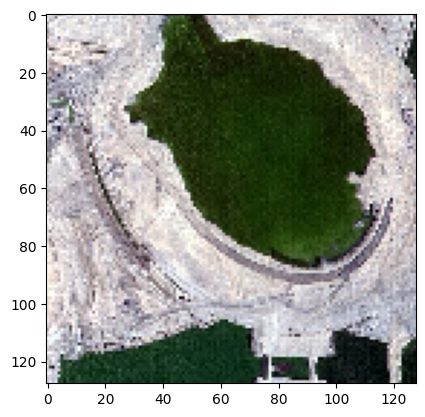

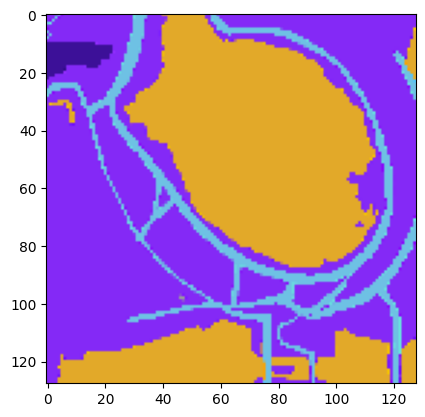

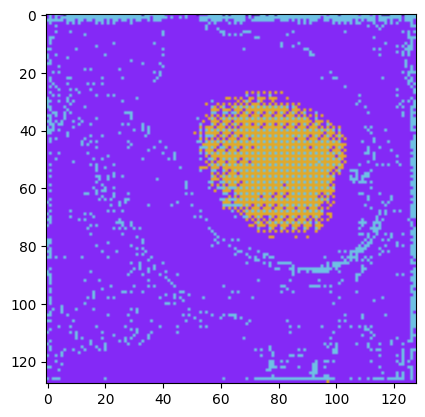

In [48]:
I = 0 # номер картинки после обработки нейронной сетью
plt.imshow(np.array(X_test)[I])
plt.show()
plt.imshow(np.array(Y_test)[I])
plt.show()
plt.imshow(convert_to_color(np.argmax(out[I], axis=-1)))
plt.show()


Очень условная сегментация

In [25]:
CLASSES=2

In [26]:
#Функция для подсчёта DICE коэффициента
def dice_coef(y_pred, y_true):
    y_pred = tf.unstack(y_pred, axis=3)
    y_true = tf.unstack(y_true, axis=3)
    dice_summ = 0

    for i, (a_y_pred, b_y_true) in enumerate(zip(y_pred, y_true)):
        dice_calculate = (2 * tf.math.reduce_sum(a_y_pred * b_y_true) + 1) /\
         (tf.math.reduce_sum(a_y_pred + b_y_true) + 1)

        dice_summ += dice_calculate
    avg_dice = dice_summ/CLASSES
    return avg_dice

In [27]:
#Функция для подсчета DICE loss
def dice_loss(y_pred, y_true):
    d_loss = 1 - dice_coef(y_pred, y_true)
    return d_loss

In [28]:
import keras.losses

In [29]:
# Binary crossentropy + 0.25 * DICE
def dice_bce_loss(y_pred, y_true):
    total_loss = 0.25 * dice_loss(y_pred, y_true) + keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss

In [51]:
dice_bce_loss(arg1, arg2)

NameError: name 'arg1' is not defined

что сюда ставить не понял.<br>
out - numpy.ndarray с дробными значениями от 0 до 1,<br>
Y_test_pred - вроде бы что то такое должно быть, но тоже не очень понятно каким боком пристроить, при том, что про второй аргумент вообще не ясно.